In [110]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

In [2]:
cba = pd.read_excel('CBAmax.xls')

In [3]:
cba.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-10-01,6.78662,6.78662,6.78662,6.78662,1.290987,0
1,1991-10-02,6.78662,6.78662,6.78662,6.78662,1.290987,0
2,1991-10-03,6.78662,6.78662,6.78662,6.78662,1.290987,0
3,1991-10-04,6.78662,6.78662,6.78662,6.78662,1.290987,0
4,1991-10-07,6.78662,6.78662,6.78662,6.78662,1.290987,0


In [4]:
cba.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7856,2022-09-29,93.830002,94.190002,93.120003,93.120003,93.120003,2094138
7857,2022-09-30,93.220001,93.230003,90.260002,90.699997,90.699997,3741428
7858,2022-10-03,91.150002,91.370003,89.660004,90.610001,90.610001,2038034
7859,2022-10-04,92.000000,94.870003,91.889999,94.790001,94.790001,3030551
7860,2022-10-05,95.989998,97.599998,95.790001,97.290001,97.290001,3840988


In [5]:
cba.columns = cba.columns.str.lower()

In [6]:
cba['movement'] = cba['close']-cba['open']

In [7]:
cba.head()

,date,open,high,low,close,adj close,volume,movement
0,1991-10-01,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
1,1991-10-02,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
2,1991-10-03,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
3,1991-10-04,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
4,1991-10-07,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0


In [168]:
cba.shape

(7861, 8)

<Figure size 720x576 with 0 Axes>

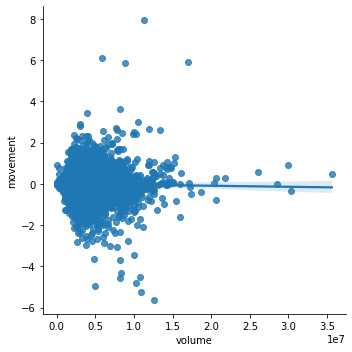

In [111]:
plt.figure(figsize=(10,8))
sns.lmplot(x='volume', y='movement', data=cba);
plt.savefig('cbamovement')
plt.show()

<AxesSubplot:>

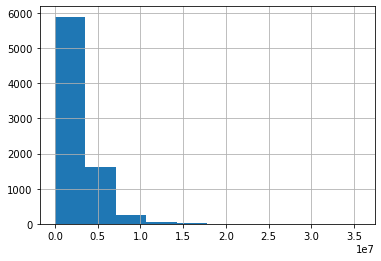

In [115]:
cba['volume'].hist()

<AxesSubplot:>

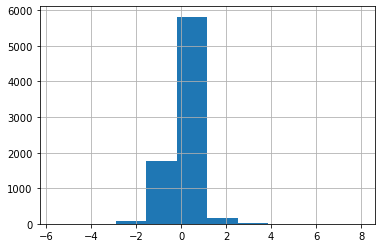

In [116]:
cba['movement'].hist()

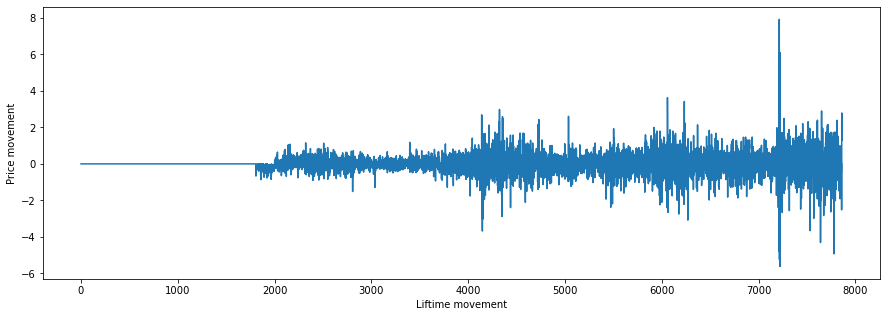

In [118]:
cba['movement'].plot(style='-', figsize=(15, 5))
plt.ylabel('Price movement')
plt.xlabel('Liftime movement')
plt.savefig('LifetimeMovement')
plt.show()

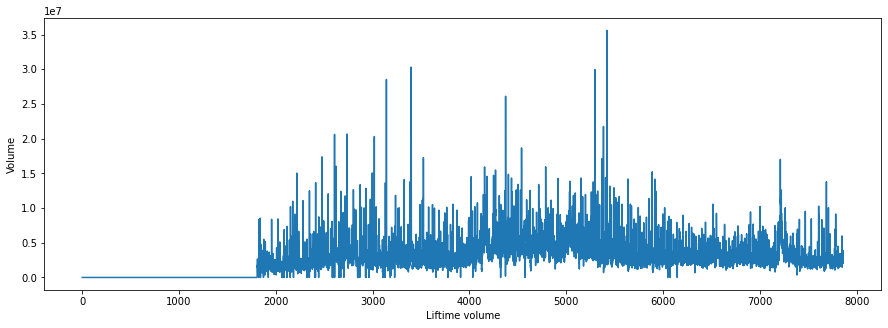

In [119]:
cba['volume'].plot(style='-', figsize=(15, 5))
plt.ylabel('Volume')
plt.xlabel('Liftime volume')
plt.savefig('LifetimeVolume')
plt.show()

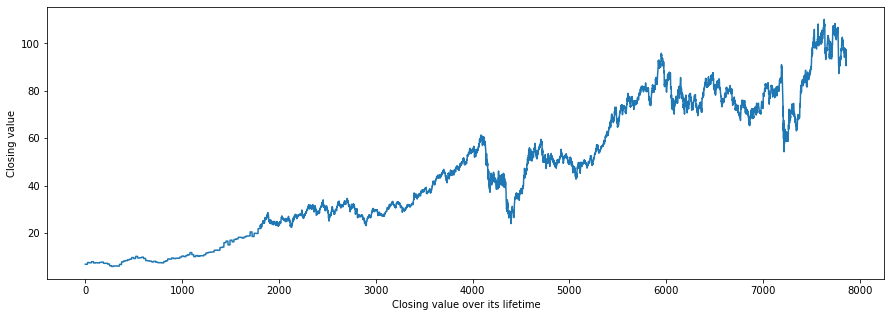

In [120]:
cba['close'].plot(style='-', figsize=(15, 5))
plt.ylabel('Closing value')
plt.xlabel('Closing value over its lifetime')
plt.savefig('Closing price')
plt.show()
plt.show()

In [14]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [15]:
datetime_object = str_to_datetime('2017-09-21')
datetime_object

datetime.datetime(2017, 9, 21, 0, 0)

In [16]:
cba_mm = cba.drop(labels = ['open', 'high', 'low', 'close', 'adj close', 'volume'], axis=1)

In [17]:
cba_mm

,date,movement
0,1991-10-01,0.000000
1,1991-10-02,0.000000
2,1991-10-03,0.000000
3,1991-10-04,0.000000
4,1991-10-07,0.000000
...,...,...
7856,2022-09-29,-0.709999
7857,2022-09-30,-2.520004
7858,2022-10-03,-0.540001
7859,2022-10-04,2.790001


In [18]:
cba_mm.index = cba_mm.pop('date')

In [19]:
cba_mm

,movement
date,
1991-10-01,0.000000
1991-10-02,0.000000
1991-10-03,0.000000
1991-10-04,0.000000
1991-10-07,0.000000
...,...
2022-09-29,-0.709999
2022-09-30,-2.520004
2022-10-03,-0.540001


In [ ]:
def create_features(cba_mm):
    """
    Create time series features based on time series index.
    """
    cba_mm['dayofweek'] = cba_mm.index.dayofweek
    cba_mm['quarter'] = cba_mm.index.quarter
    cba_mm['month'] = cba_mm.index.month
    cba_mm['year'] = cba_mm.index.year
    return cba_mm


In [ ]:
cba_mm = create_features(cba_mm)

In [23]:
cba_mm

,movement,dayofweek,quarter,month,year
date,,,,,
1991-10-01,0.000000,1,4,10,1991
1991-10-02,0.000000,2,4,10,1991
1991-10-03,0.000000,3,4,10,1991
1991-10-04,0.000000,4,4,10,1991
1991-10-07,0.000000,0,4,10,1991
...,...,...,...,...,...
2022-09-29,-0.709999,3,3,9,2022
2022-09-30,-2.520004,4,3,9,2022
2022-10-03,-0.540001,0,4,10,2022


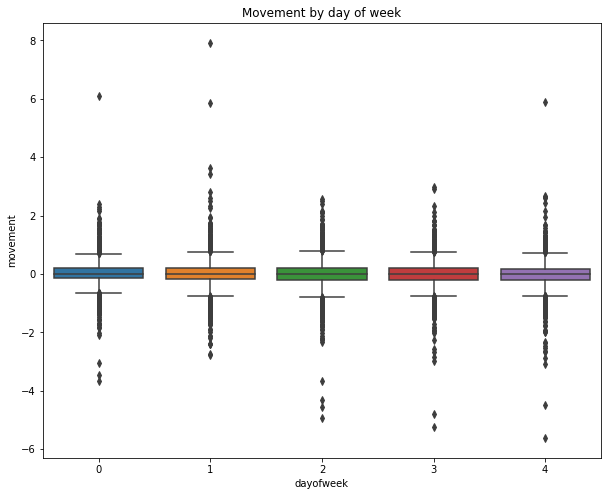

In [169]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cba_mm, x='dayofweek', y='movement')
ax.set_title('Movement by day of week')
plt.savefig('Movement by day of week')
plt.show()

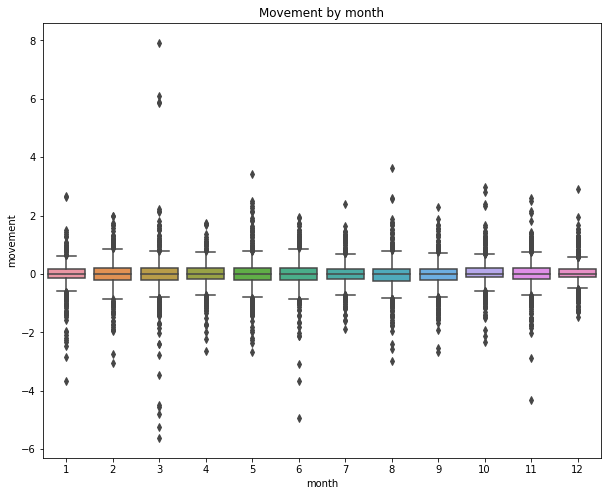

In [123]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cba_mm, x='month', y='movement')
ax.set_title('Movement by month')
plt.savefig('Movement by month')
plt.show()

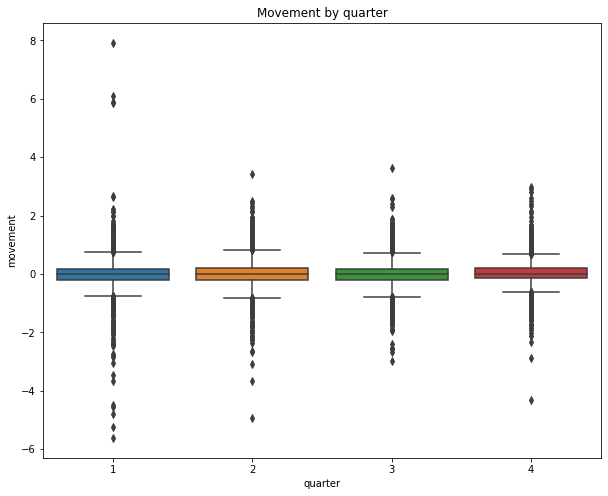

In [124]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cba_mm, x='quarter', y='movement')
ax.set_title('Movement by quarter')
plt.savefig('Movement by quarter')
plt.show()

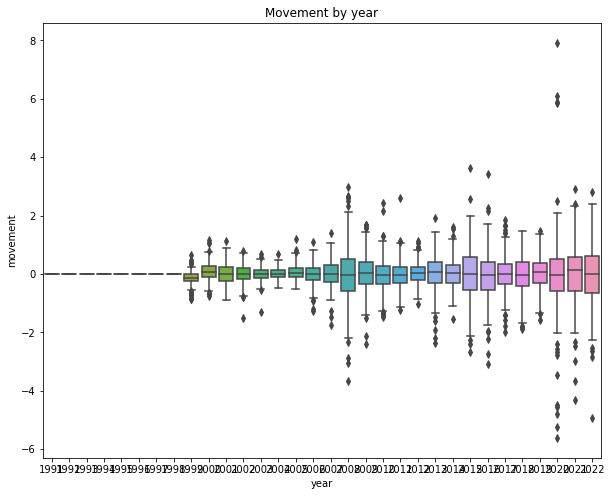

In [125]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cba_mm, x='year', y='movement')
ax.set_title('Movement by year')
plt.savefig('Movement by year')
plt.show()

### Converting data to Supervised learning problem

In [128]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3): #3days before target day
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['movement'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [129]:
# Start day second time around 
windowed_df = df_to_windowed_df(cba_mm, 
                                '1991-10-04', 
                                '2022-10-05', 
                                n=3)
windowed_df

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

### Convert data to numpy array

In [130]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # Using 1 for Univariate forecasting

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((7858,), (7858, 3, 1), (7858,))

### Split data into Train and Test

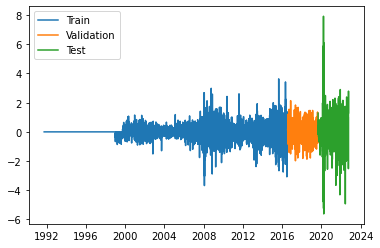

In [131]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.savefig('Dataset split')

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

2022-10-07 16:28:49.246633: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
197/197 [==============================] - 2s 5ms/step - loss: 0.1902 - mean_absolute_error: 0.2584 - val_loss: 0.3538 - val_mean_absolute_error: 0.4678
Epoch 2/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1899 - mean_absolute_error: 0.2564 - val_loss: 0.3534 - val_mean_absolute_error: 0.4674
Epoch 3/100
197/197 [==============================] - 1s 4ms/step - loss: 0.1897 - mean_absolute_error: 0.2581 - val_loss: 0.3544 - val_mean_absolute_error: 0.4686
Epoch 4/100
197/197 [==============================] - 1s 4ms/step - loss: 0.1898 - mean_absolute_error: 0.2561 - val_loss: 0.3532 - val_mean_absolute_error: 0.4677
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1897 - mean_absolute_error: 0.2562 - val_loss: 0.3534 - val_mean_absolute_error: 0.4679
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1897 - mean_absolute_error: 0.2568 - val_loss: 0.3529 - val_mean_absolute_error: 0.4675
Epoch 7/10

197/197 [==============================] - 1s 3ms/step - loss: 0.1806 - mean_absolute_error: 0.2529 - val_loss: 0.3558 - val_mean_absolute_error: 0.4714
Epoch 51/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1802 - mean_absolute_error: 0.2525 - val_loss: 0.3578 - val_mean_absolute_error: 0.4714
Epoch 52/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1799 - mean_absolute_error: 0.2542 - val_loss: 0.3532 - val_mean_absolute_error: 0.4683
Epoch 53/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1797 - mean_absolute_error: 0.2537 - val_loss: 0.3554 - val_mean_absolute_error: 0.4705
Epoch 54/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1798 - mean_absolute_error: 0.2532 - val_loss: 0.3576 - val_mean_absolute_error: 0.4710
Epoch 55/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1792 - mean_absolute_error: 0.2533 - val_loss: 0.3570 - val_mean_absolute_error: 0.4701
Epoch 56/100
197/

197/197 [==============================] - 1s 4ms/step - loss: 0.1692 - mean_absolute_error: 0.2479 - val_loss: 0.3631 - val_mean_absolute_error: 0.4742
Epoch 100/100
197/197 [==============================] - 1s 4ms/step - loss: 0.1690 - mean_absolute_error: 0.2471 - val_loss: 0.3611 - val_mean_absolute_error: 0.4742


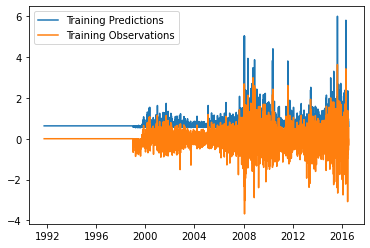

In [134]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.savefig('Training&Prediction')

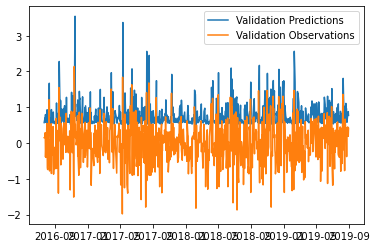

In [137]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.savefig('Val&Prediction')

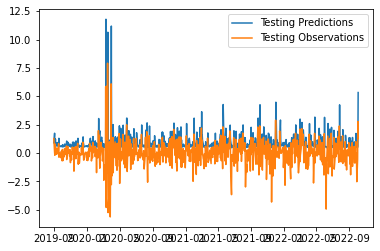

In [139]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.savefig('Test&Prediction')

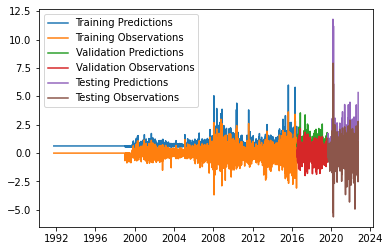

In [142]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.savefig('Predictions')

In [143]:
rms=np.sqrt(np.mean(np.power((val_predictions),2)))
rms

0.84616804

In [178]:
error = rmse(test_predictions,y_test)
error

1.8068826

In [145]:
y_test.mean()

-0.005725458

In [179]:
test_predictions.mean()

0.95723003

In [180]:
(((test_predictions.mean()*100)/y_test.mean())/100)-1

-168.18838303365175

### Recursive prediction using training data to predict val and test dates

In [148]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

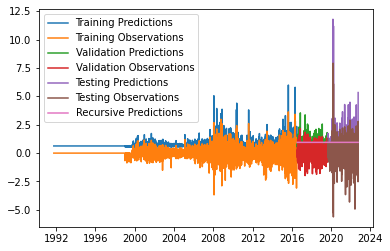

In [151]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])
plt.savefig('PredictionAll')

In [152]:
rms_recursive=np.sqrt(np.mean(np.power((recursive_predictions),2)))
rms_recursive

0.9470097

### Predicting Closing value

In [42]:
cba

,date,open,high,low,close,adj close,volume,movement
0,1991-10-01,6.786620,6.786620,6.786620,6.786620,1.290987,0,0.000000
1,1991-10-02,6.786620,6.786620,6.786620,6.786620,1.290987,0,0.000000
2,1991-10-03,6.786620,6.786620,6.786620,6.786620,1.290987,0,0.000000
3,1991-10-04,6.786620,6.786620,6.786620,6.786620,1.290987,0,0.000000
4,1991-10-07,6.786620,6.786620,6.786620,6.786620,1.290987,0,0.000000
...,...,...,...,...,...,...,...,...
7856,2022-09-29,93.830002,94.190002,93.120003,93.120003,93.120003,2094138,-0.709999
7857,2022-09-30,93.220001,93.230003,90.260002,90.699997,90.699997,3741428,-2.520004
7858,2022-10-03,91.150002,91.370003,89.660004,90.610001,90.610001,2038034,-0.540001
7859,2022-10-04,92.000000,94.870003,91.889999,94.790001,94.790001,3030551,2.790001


In [45]:
cbac = cba.copy()

In [46]:
cbac = cbac.drop(labels = ['open', 'high', 'low', 'movement', 'adj close', 'volume'], axis=1)

In [47]:
cbac

,date,close
0,1991-10-01,6.786620
1,1991-10-02,6.786620
2,1991-10-03,6.786620
3,1991-10-04,6.786620
4,1991-10-07,6.786620
...,...,...
7856,2022-09-29,93.120003
7857,2022-09-30,90.699997
7858,2022-10-03,90.610001
7859,2022-10-04,94.790001


In [48]:
cbac.index = cbac.pop('date')

In [49]:
cbac

,close
date,
1991-10-01,6.786620
1991-10-02,6.786620
1991-10-03,6.786620
1991-10-04,6.786620
1991-10-07,6.786620
...,...
2022-09-29,93.120003
2022-09-30,90.699997
2022-10-03,90.610001


In [52]:
def create_features(cbac):
    """
    Create time series features based on time series index.
    """
    cbac['dayofweek'] = cbac.index.dayofweek
    cbac['quarter'] = cbac.index.quarter
    cbac['month'] = cbac.index.month
    cbac['year'] = cbac.index.year
    return cbac


In [53]:
cbac = create_features(cbac)

In [54]:
cbac

,close,dayofweek,quarter,month,year
date,,,,,
1991-10-01,6.786620,1,4,10,1991
1991-10-02,6.786620,2,4,10,1991
1991-10-03,6.786620,3,4,10,1991
1991-10-04,6.786620,4,4,10,1991
1991-10-07,6.786620,0,4,10,1991
...,...,...,...,...,...
2022-09-29,93.120003,3,3,9,2022
2022-09-30,90.699997,4,3,9,2022
2022-10-03,90.610001,0,4,10,2022


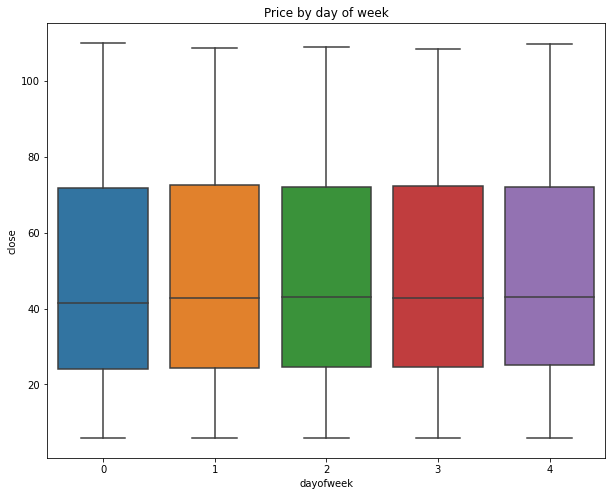

In [153]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cbac, x='dayofweek', y='close')
ax.set_title('Price by day of week')
plt.savefig('CloseByDayOfWeek')
plt.show()

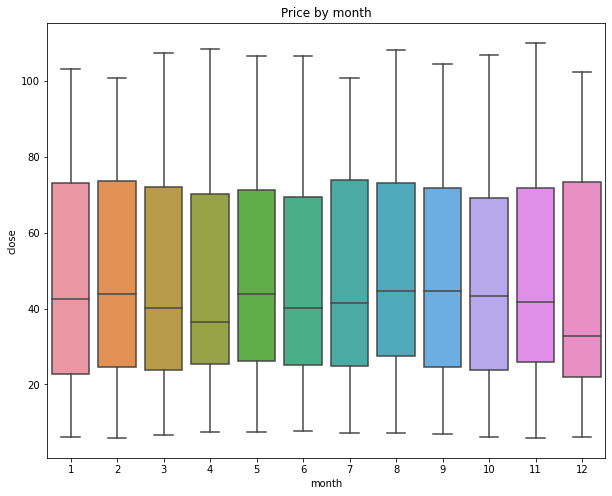

In [154]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cbac, x='month', y='close')
ax.set_title('Price by month')
plt.savefig('CloseByMonth')
plt.show()

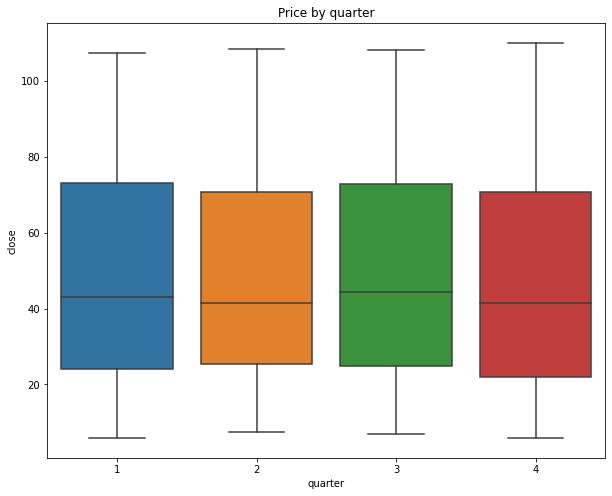

In [155]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cbac, x='quarter', y='close')
ax.set_title('Price by quarter')
plt.savefig('CloseByQuarter')
plt.show()

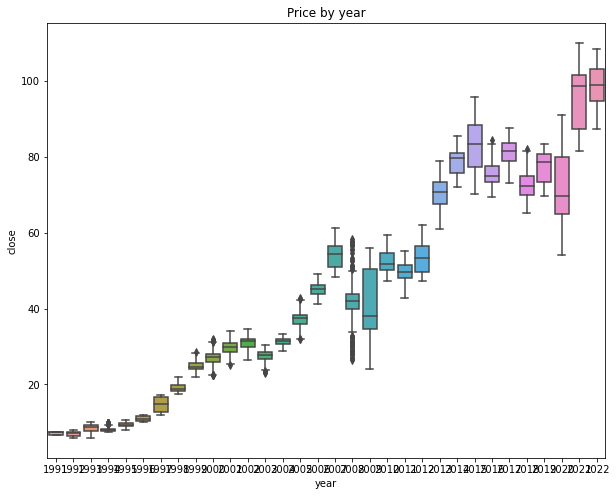

In [156]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cbac, x='year', y='close')
ax.set_title('Price by year')
plt.savefig('CloseByYear')
plt.show()

### Converting data to Supervised learning problem

In [61]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3): #3days before target day
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [62]:
# Start day second time around 
windowed_dfc = df_to_windowed_df(cbac, 
                                '1991-10-04', 
                                '2022-10-05', 
                                n=3)
windowed_dfc

,Target Date,Target-3,Target-2,Target-1,Target
0,1991-10-04,6.786620,6.786620,6.786620,6.786620
1,1991-10-07,6.786620,6.786620,6.786620,6.786620
2,1991-10-08,6.786620,6.786620,6.786620,6.786620
3,1991-10-09,6.786620,6.786620,6.786620,6.786620
4,1991-10-10,6.786620,6.786620,6.786620,6.786620
...,...,...,...,...,...
7853,2022-09-29,93.610001,93.430000,92.540001,93.120003
7854,2022-09-30,93.430000,92.540001,93.120003,90.699997
7855,2022-10-03,92.540001,93.120003,90.699997,90.610001
7856,2022-10-04,93.120003,90.699997,90.610001,94.790001


### Convert data to numpy array

In [65]:
def windowed_dfc_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  datesc = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  Xc = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # Using 1 for Univariate forecasting

  Yc = df_as_np[:, -1]

  return datesc, Xc.astype(np.float32), Yc.astype(np.float32)

datesc, Xc, yc = windowed_dfc_to_date_X_y(windowed_dfc)

datesc.shape, Xc.shape, yc.shape

((7858,), (7858, 3, 1), (7858,))

### Split data into Train and Test

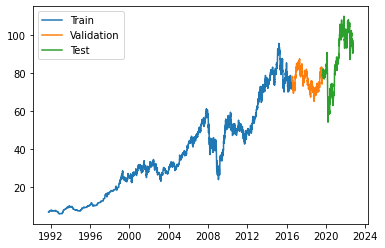

In [157]:
q_80 = int(len(datesc) * .8)
q_90 = int(len(datesc) * .9)

datesc_train, Xc_train, yc_train = datesc[:q_80], Xc[:q_80], yc[:q_80]

datesc_val, Xc_val, yc_val = datesc[q_80:q_90], Xc[q_80:q_90], yc[q_80:q_90]
datesc_test, Xc_test, yc_test = datesc[q_90:], Xc[q_90:], yc[q_90:]

plt.plot(datesc_train, yc_train)
plt.plot(datesc_val, yc_val)
plt.plot(datesc_test, yc_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.savefig('DataSplitClose')

In [172]:
print(len(datesc_train))
print(len(datesc_val))
print(len(datesc_test))

6286
786
786


In [67]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(Xc_train, yc_train, validation_data=(Xc_val, yc_val), epochs=100)

Epoch 1/100
197/197 [==============================] - 3s 5ms/step - loss: 713.4640 - mean_absolute_error: 16.6130 - val_loss: 1.5519 - val_mean_absolute_error: 0.9943
Epoch 2/100
197/197 [==============================] - 1s 3ms/step - loss: 0.6693 - mean_absolute_error: 0.4586 - val_loss: 0.7053 - val_mean_absolute_error: 0.6374
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4842 - mean_absolute_error: 0.4456 - val_loss: 1.0412 - val_mean_absolute_error: 0.8022
Epoch 4/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4468 - mean_absolute_error: 0.4418 - val_loss: 0.6439 - val_mean_absolute_error: 0.6101
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 0.3934 - mean_absolute_error: 0.4053 - val_loss: 1.0584 - val_mean_absolute_error: 0.8059
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4548 - mean_absolute_error: 0.4499 - val_loss: 0.7464 - val_mean_absolute_error: 0.6559
Epoch 7

197/197 [==============================] - 1s 3ms/step - loss: 0.3641 - mean_absolute_error: 0.4005 - val_loss: 0.6292 - val_mean_absolute_error: 0.6068
Epoch 51/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4391 - mean_absolute_error: 0.4471 - val_loss: 0.6295 - val_mean_absolute_error: 0.5955
Epoch 52/100
197/197 [==============================] - 1s 3ms/step - loss: 0.3946 - mean_absolute_error: 0.4147 - val_loss: 0.9911 - val_mean_absolute_error: 0.7756
Epoch 53/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4230 - mean_absolute_error: 0.4440 - val_loss: 0.6480 - val_mean_absolute_error: 0.6202
Epoch 54/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4137 - mean_absolute_error: 0.4200 - val_loss: 1.3011 - val_mean_absolute_error: 0.9304
Epoch 55/100
197/197 [==============================] - 1s 3ms/step - loss: 0.4483 - mean_absolute_error: 0.4606 - val_loss: 0.6855 - val_mean_absolute_error: 0.6372
Epoch 56/100
197/

197/197 [==============================] - 1s 3ms/step - loss: 0.3666 - mean_absolute_error: 0.3983 - val_loss: 0.8459 - val_mean_absolute_error: 0.7301
Epoch 100/100
197/197 [==============================] - 1s 3ms/step - loss: 0.3613 - mean_absolute_error: 0.3914 - val_loss: 0.7160 - val_mean_absolute_error: 0.6594


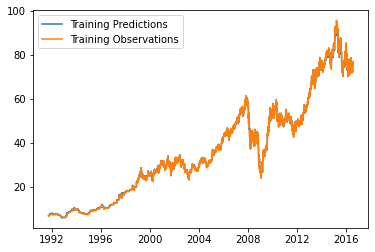

In [159]:
trainc_predictions = model.predict(Xc_train).flatten()

plt.plot(datesc_train, trainc_predictions)
plt.plot(datesc_train, yc_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.savefig('Train&PredictionClose')

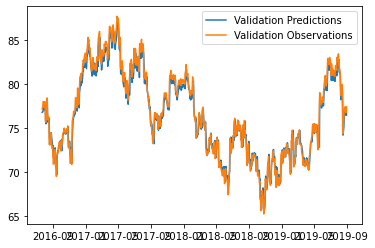

In [160]:
valc_predictions = model.predict(Xc_val).flatten()

plt.plot(datesc_val, valc_predictions)
plt.plot(datesc_val, yc_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.savefig('Val&PredictionClose')

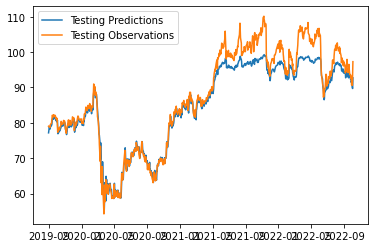

In [161]:
testc_predictions = model.predict(Xc_test).flatten()

plt.plot(datesc_test, testc_predictions)
plt.plot(datesc_test, yc_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.savefig('Test&PredictionClose')

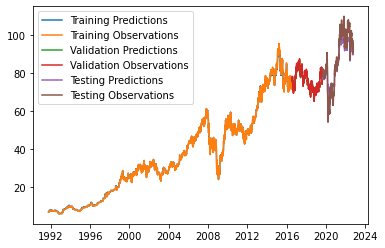

In [177]:
plt.plot(datesc_train, trainc_predictions)
plt.plot(datesc_train, yc_train)
plt.plot(datesc_val, valc_predictions)
plt.plot(datesc_val, yc_val)
plt.plot(datesc_test, testc_predictions)
plt.plot(datesc_test, yc_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.savefig('PredictionsClose')

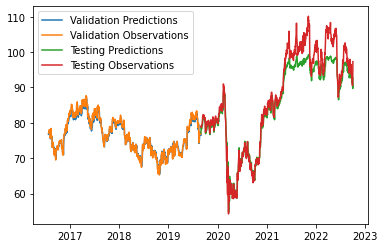

In [176]:
#plt.plot(datesc_train, trainc_predictions)
#plt.plot(datesc_train, yc_train)
plt.plot(datesc_val, valc_predictions)
plt.plot(datesc_val, yc_val)
plt.plot(datesc_test, testc_predictions)
plt.plot(datesc_test, yc_test)
plt.legend([#'Training Predictions', 
            #'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
#plt.savefig('PredictionsClose')

In [163]:
rms=np.sqrt(np.mean(np.power((valc_predictions),2)))
rms

76.459045

In [173]:
rmse_c = rmse(testc_predictions, yc_test)
rmse_c

3.4819007

In [102]:
yc_test.mean()

87.06204

In [174]:
testc_predictions.mean()

84.97674

In [107]:
(((valc_predictions.mean()*100)/yc_test.mean())/100)-1

-0.12339813638927266

### Recursive prediction using training data to predict val and test dates

In [74]:
recursivec_predictions = []
recursivec_dates = np.concatenate([datesc_val, datesc_test])

for target_date in recursivec_dates:
  last_windowc = deepcopy(Xc_train[-1])
  next_predictionc = model.predict(np.array([last_windowc])).flatten()
  recursivec_predictions.append(next_predictionc)
  last_windowc[-1] = next_predictionc

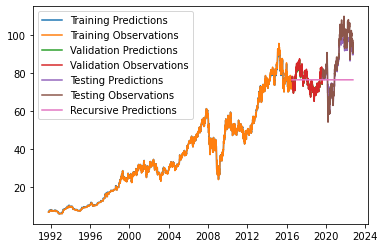

In [165]:
plt.plot(datesc_train, trainc_predictions)
plt.plot(datesc_train, yc_train)
plt.plot(datesc_val, valc_predictions)
plt.plot(datesc_val, yc_val)
plt.plot(datesc_test, testc_predictions)
plt.plot(datesc_test, yc_test)
plt.plot(recursivec_dates, recursivec_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])
plt.savefig('PredictionCloseRecursive')

In [166]:
rms_recursive=np.sqrt(np.mean(np.power((recursivec_predictions),2)))
rms_recursive

76.60035

In [167]:
error = rmse(valc_predictions,yc_val)
error

0.84615034